In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmadrazakashif/bmw-worldwide-sales-records-20102024")

print("Path to dataset files:", path)

100%|██████████| 833k/833k [00:00<00:00, 45.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ahmadrazakashif/bmw-worldwide-sales-records-20102024/versions/1


In [1]:
!pip -q install pandas numpy scikit-learn category-encoders

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.9 MB/s eta 0:00:00


In [4]:
import kagglehub, os, glob
path = kagglehub.dataset_download("ahmadrazakashif/bmw-worldwide-sales-records-20102024")
csv_candidates = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
df = pd.read_csv(csv_candidates[0])

Using Colab cache for faster access to the 'bmw-worldwide-sales-records-20102024' dataset.


In [5]:
print("Shape:", df.shape)
print("Tipos:\n", df.dtypes)
print("Nulos (%):\n", df.isna().mean().sort_values(ascending=False).head(15))

Shape: (50000, 11)
Tipos:
 Model                    object
Year                      int64
Region                   object
Color                    object
Fuel_Type                object
Transmission             object
Engine_Size_L           float64
Mileage_KM                int64
Price_USD                 int64
Sales_Volume              int64
Sales_Classification     object
dtype: object
Nulos (%):
 Model                   0.0
Year                    0.0
Region                  0.0
Color                   0.0
Fuel_Type               0.0
Transmission            0.0
Engine_Size_L           0.0
Mileage_KM              0.0
Price_USD               0.0
Sales_Volume            0.0
Sales_Classification    0.0
dtype: float64


In [14]:
!pip -q install scikit-learn

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


               modelo  accuracy  precision  recall        f1
0  LogisticRegression    0.9983   0.998300  0.9983  0.998300
1                 LDA    0.9023   0.915981  0.9023  0.899182
2          GaussianNB    0.9023   0.915981  0.9023  0.899182


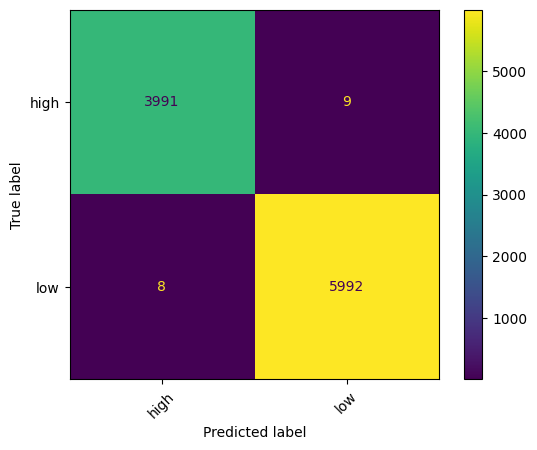

In [15]:
preprocessor = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "GaussianNB": GaussianNB()
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()<=20 else None
)

def eval_model(name, pipe, X_te, y_te, average="weighted"):
    y_pred = pipe.predict(X_te)
    return {
        "modelo": name,
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_te, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_te, y_pred, average=average, zero_division=0)
    }

results = []
trained = {}
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X_train, y_train)
    trained[name] = pipe
    results.append(eval_model(name, pipe, X_test, y_test, average="weighted"))

import pandas as pd
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
print(results_df)

best_name = results_df.iloc[0]["modelo"]
best_pipe = trained[best_name]
y_pred_best = best_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best, labels=sorted(pd.Series(y).unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(pd.Series(y).unique()))
disp.plot(xticks_rotation=45)


In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(name, pipe, X_test, y_test, average="weighted"):
    y_pred = pipe.predict(X_test)
    return {
        "modelo": name,
        "acuracia": accuracy_score(y_test, y_pred),
        "precisao": precision_score(y_test, y_pred, average=average, zero_division=0),
        "recall": recall_score(y_test, y_pred, average=average, zero_division=0),
        "f1": f1_score(y_test, y_pred, average=average, zero_division=0)
    }

results = []
for name, pipe in trained.items():
    results.append(evaluate_model(name, pipe, X_test, y_test, average="weighted"))

tabela_metricas = pd.DataFrame(results).sort_values(by="f1", ascending=False)
tabela_metricas


,modelo,acuracia,precisao,recall,f1
0,LogisticRegression,0.9983,0.998300,0.9983,0.998300
1,LDA,0.9023,0.915981,0.9023,0.899182
2,GaussianNB,0.9023,0.915981,0.9023,0.899182


In [17]:
from sklearn.metrics import classification_report

y_pred_best = trained[tabela_metricas.iloc[0]["modelo"]].predict(X_test)
print(classification_report(y_test, y_pred_best, digits=3))


              precision    recall  f1-score   support

        high      0.998     0.998     0.998      4000
         low      0.999     0.999     0.999      6000

    accuracy                          0.998     10000
   macro avg      0.998     0.998     0.998     10000
weighted avg      0.998     0.998     0.998     10000



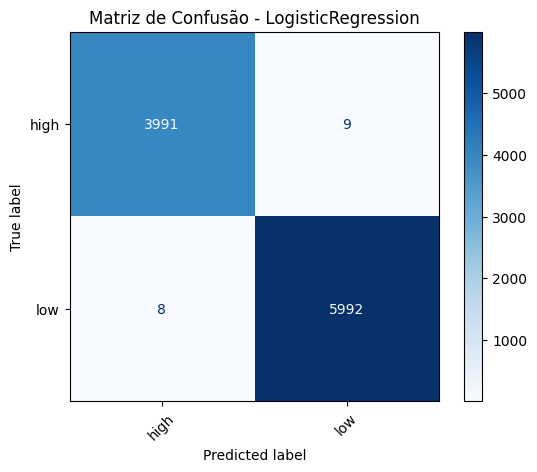

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = sorted(pd.Series(y_test).unique())
cm = confusion_matrix(y_test, y_pred_best, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title(f"Matriz de Confusão - {tabela_metricas.iloc[0]['modelo']}")
plt.show()


In [19]:
tabela_metricas.to_csv("tabela_metricas_test.csv", index=False)
tabela_metricas


,modelo,acuracia,precisao,recall,f1
0,LogisticRegression,0.9983,0.998300,0.9983,0.998300
1,LDA,0.9023,0.915981,0.9023,0.899182
2,GaussianNB,0.9023,0.915981,0.9023,0.899182
